In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true";
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00";
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async";
print(os.environ.get("TF_GPU_ALLOCATOR"))
print(os.environ.get("XLA_PYTHON_CLIENT_PREALLOCATE"))
import jax
jax.config.update("jax_enable_x64", True);
print(jax.devices());
print(jax.local_devices());

import jax.numpy as jnp;
from types import SimpleNamespace;
from pathlib import Path
import numpy as np
from functools import partial
from gnlse_medium import *
from gnlse_source import *

from gnlse_solver import *
from gnlse_events import *
from gnlse_visualizations import *
import matplotlib.pyplot as plt
import gc; 
gc.collect();


jr64 = 'float64';
jc128 = 'complex128';

def mem_diagnostics():
    dev = jax.devices()[0]
    stats = dev.memory_stats() 
    def gb(x): return x / 1e9

    print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
    print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
    print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
    print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

None
true
[CudaDevice(id=0)]
[CudaDevice(id=0)]


/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
mem_diagnostics();
jax.clear_caches()

used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB


In [3]:
#########################################################################################
'''Spatio-temporal params: '''

Nx = Ny = 400;
Lx = Ly = 300e-6;
Lz = 1e-2;
Lt = 1.50e-12; # Length of time in seconds
Nt = 1; # Number of time steps
dx = Lx/Nx;
dy = Ly/Ny;


X, Y = make_space(Lx, Nx, Ly, Ny);

In [4]:
lambda0 = 1064e-9; # central wavelength


# assume dx, dy, X, Y already defined; D_in is 1/e^2 diameter
power = 0.545e6  # W
D_in = 60e-6
w_in = D_in/2.0  # 1/e^2 radius

g_amp = jnp.exp(-(X**2 + Y**2)/w_in**2)           # amplitude shape
shape = g_amp**2                                  # intensity shape = exp(-2 r^2 / w^2)
norm  = jnp.sum(shape) * dx * dy                  # ∑ s_ij ΔxΔy
E0    = jnp.sqrt(power / norm)                    # <-- no (dx*dy) in denominator here
Ein   = E0 * g_amp

I_xy = jnp.abs(Ein)**2
P_xy = jnp.sum(I_xy) * dx * dy
print("power: ", float(P_xy)*1e-6, " MW")         # ≈ 20.0 MW


power:  0.545  MW


In [5]:
n_clad =1.44;
n_core = 1.44;
nxy = jnp.ones((Nx, Ny), dtype=jr64) * 1.44; # uniform index profile
n_xyomega = jnp.tile(nxy[:,:,None], (1,1 , Nt));

In [6]:
''' Define temporal profile '''
phis = 0.0;
t0 = 0.0;
fwhm = 120e-15; ''' 120 fs '''
phase = 0.0;
omega0 = 2 * jnp.pi / lambda0; ''' Carrier frequency in rad/s '''
T = jnp.linspace(-Lt/2, Lt/2, Nt); # time grid`

lambdas = jnp.array([1030e-9])
phis    = jnp.array([0.0])

#E_t_cw  = cw_temp_profile_freq(lambdas, phis, Lt, Nt)
# Gaussian: 150 fs FWHM, centered at t0=0, with a carrier shift
E_t_gauss = gaussian_pulse_profile_freq(t0=0.0, fwhm=150e-15, Lt=Lt, Nt=Nt, carrier_omega=0.0, phase=0.0)

(400, 400, 1)


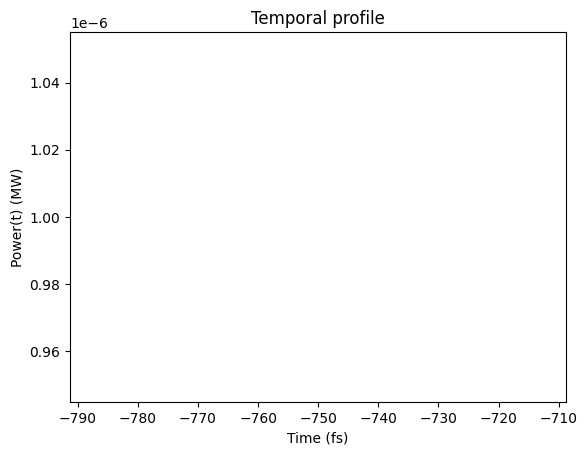

In [7]:
plt.figure();
plt.plot(T * 1e15, np.abs(E_t_gauss)**2 / 1e6);
plt.xlabel("Time (fs)"); plt.ylabel("Power(t) (MW)");
plt.title("Temporal profile");

field = combine_spatial_temporal(Ein, E_t_gauss) ;
print(jnp.shape(field));

power:  0.5450000000000002  MW


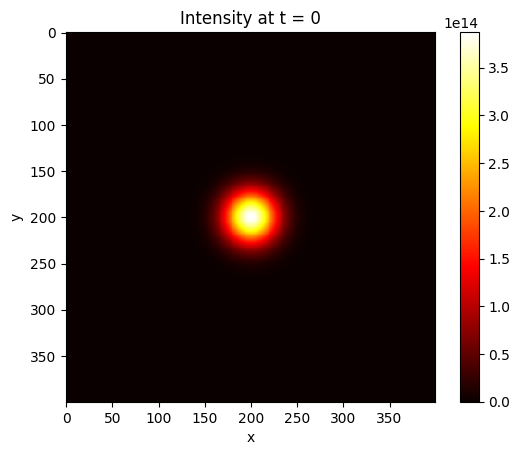

In [8]:
t_index =  int(Nt / 2); # Time index to visualize
I_xy = jnp.real(field[:, :, t_index])**2 + jnp.imag(field[:, :, t_index])**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy / 1e6, " MW");


plt.figure()
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity at t = {t_index}");
plt.xlabel("x");    plt.ylabel("y");
plt.show();

In [9]:
#############################################################################################
''' Define remaining params: '''
c = 2.998e8;
beta0 = n_core * 2 * jnp.pi / lambda0;
print("beta0: ", beta0);
n_g = 1.468; # group index
beta1 = n_g / c;
beta2 = 22e-27; # 1.0; # Dispersion coefficient in s^2/m
n2 = 2.22e-20; ''' 2.22e-20 m^2/W '''
omega = None;

pml_thickness = 40;
pml_Wmax = 1e12;
''' args '''



beta0:  8503559.062348312


' args '

In [10]:
# override from previous cells:
Lz = 4e-2; # Length of propagation in z
save_at = jnp.linspace(0, Lz, 100, endpoint=True); # save at these positions in z
print(save_at)
n2 = 2.22e-20

##########
args = {"Lx" : Lx, "Ly": Ly, "Lz": Lz, "Lt": Lt,   # spatiotemporal dimensions
        "Nx": Nx, "Ny": Ny, "Nt": Nt,              # spatial and temporal grid
        "n_xyomega": n_xyomega, "n2": n2, "nref": n_clad, # potential params
        "beta0": beta0, "beta1" : beta1,       # propagation params
        "beta2": beta2, "lambda0": lambda0,    # propagation params
        "save_at": save_at,                   # array of z positions to save at
        "deltaZ": 1e-6,                       # linear step size
        "deltaZ_NL":1e-5,                      # nonlinear step size
        "saturation_intensity": 5e-5,          #
        "gain_coeff": 0.0,
        "gain_fwhm": 0.0,
        "t1": 12.2e-15, "t2": 32e-15,       
        "pml_thickness": pml_thickness, "pml_Wmax": pml_Wmax, # pml_Wmax,
        "fr": 0.0, "sw": 0                   # raman fraction (0.0 for no raman) and 
       };

mem_diagnostics();

[0.         0.00040404 0.00080808 0.00121212 0.00161616 0.0020202
 0.00242424 0.00282828 0.00323232 0.00363636 0.0040404  0.00444444
 0.00484848 0.00525253 0.00565657 0.00606061 0.00646465 0.00686869
 0.00727273 0.00767677 0.00808081 0.00848485 0.00888889 0.00929293
 0.00969697 0.01010101 0.01050505 0.01090909 0.01131313 0.01171717
 0.01212121 0.01252525 0.01292929 0.01333333 0.01373737 0.01414141
 0.01454545 0.01494949 0.01535354 0.01575758 0.01616162 0.01656566
 0.0169697  0.01737374 0.01777778 0.01818182 0.01858586 0.0189899
 0.01939394 0.01979798 0.02020202 0.02060606 0.0210101  0.02141414
 0.02181818 0.02222222 0.02262626 0.0230303  0.02343434 0.02383838
 0.02424242 0.02464646 0.02505051 0.02545455 0.02585859 0.02626263
 0.02666667 0.02707071 0.02747475 0.02787879 0.02828283 0.02868687
 0.02909091 0.02949495 0.02989899 0.03030303 0.03070707 0.03111111
 0.03151515 0.03191919 0.03232323 0.03272727 0.03313131 0.03353535
 0.03393939 0.03434343 0.03474747 0.03515152 0.03555556 0.035959

In [11]:
results = GNLSE3D_propagate(args, field); 

(400, 400, 1, 100)
power:  0.5446803781449464  MW


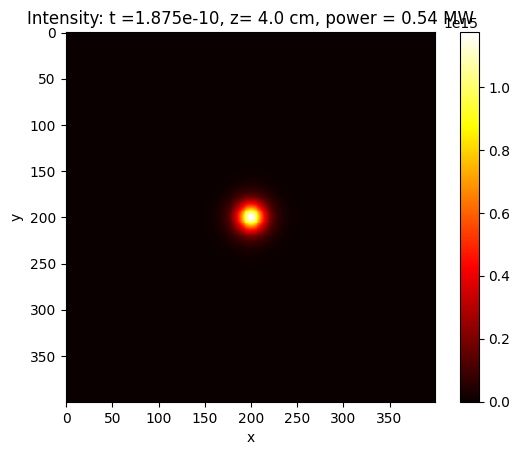

In [12]:

slot = -1; # Last save slot
time = 125; # Time slot to visualize
print(results["field"].shape);

res_field = results["field"][:, :, time, slot];

I_xy = jnp.real(res_field)**2 + jnp.imag(res_field)**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy * 1e-6 , " MW");

plt.figure();
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity: t ={time * Lt/Nt}, z= {round(save_at[slot], 3)*100} cm, power = {round(P_xy * 1e-6, 2)} MW");
plt.xlabel("x");    plt.ylabel("y");
plt.show();

In [ ]:
def make_xy_z_animation(field4d,
                        t_index=-1,
                        x=None, y=None, z=None,
                        quantity='intensity',      # 'intensity' (|E|^2), 'abs', 'real', 'imag', 'phase'
                        norm='global',             # 'global' or 'per_frame'
                        z_window=None,             # (z_start, z_end) in same units as z (ignored if z is None)
                        frame_window=None,         # (i_start, i_end) inclusive/exclusive frame indices
                        stride=1,                  # take every 'stride' frame in the selected window
                        fps=30,
                        filename='xy_z.gif',
                        dpi=120,
                        Lz = 1e-2,
                        log_scale=False,           # NEW: whether to plot in log10 scale
                        eps=1e-12):                # NEW: floor to avoid log(0)
    """
    Animate the transverse (x,y) field vs propagation distance z at a fixed time index t.
    """
    assert field4d.ndim == 4, "Expected (Nx, Ny, Nt, Nz)."
    Nx, Ny, Nt, Nz = field4d.shape
    if not (-Nt <= t_index < Nt):
        raise IndexError(f"t_index {t_index} out of range for Nt={Nt}")

    # Extract the (x,y,z) block at fixed t
    F = field4d[:, :, t_index, :]  # (Nx, Ny, Nz)

    # Map to requested quantity
    if quantity == 'intensity':
        data_z = np.abs(F)**2
        cbar_label = r'|E|$^2$'
    elif quantity == 'abs':
        data_z = np.abs(F)
        cbar_label = r'|E|'
    elif quantity == 'real':
        data_z = np.real(F)
        cbar_label = 'Re{E}'
    elif quantity == 'imag':
        data_z = np.imag(F)
        cbar_label = 'Im{E}'
    elif quantity == 'phase':
        data_z = np.angle(F)
        cbar_label = 'arg(E)'
    else:
        raise ValueError("quantity must be one of: 'intensity', 'abs', 'real', 'imag', 'phase'")

    # Apply log scale if requested (skip for phase, real, imag unless explicitly wanted)
    if log_scale:
        if quantity in ['intensity', 'abs']:
            data_z = np.log10(data_z + eps)
            cbar_label = "log₁₀(" + cbar_label + ")"
        else:
            print("Warning: log scale applied to non-magnitude quantity.")

    # Determine the z/frame subset
    if z_window is not None:
        if z is None:
            raise ValueError("z_window was provided but `z` axis is None.")
        z = np.asarray(z)
        if len(z) != Nz:
            raise ValueError("Length of `z` must match Nz dimension of field.")
        z_start, z_end = z_window
        if z_start > z_end:
            z_start, z_end = z_end, z_start
        i0 = int(np.clip(np.searchsorted(z, z_start, side='left'), 0, Nz-1))
        i1 = int(np.clip(np.searchsorted(z, z_end,   side='right'), 0, Nz))  # exclusive
    elif frame_window is not None:
        i0, i1 = frame_window
        i0 = int(np.clip(i0, 0, Nz))
        i1 = int(np.clip(i1, i0+1, Nz))  # ensure at least one frame if possible
    else:
        i0, i1 = 0, Nz

    # Apply stride
    frame_indices = np.arange(i0, i1, stride, dtype=int)
    if frame_indices.size == 0:
        raise ValueError("Selected z/frame window is empty after applying stride.")

    data_sel = data_z[..., frame_indices]              # (Nx, Ny, Nf)
    z_sel = z[frame_indices] if (z is not None and len(z) == Nz) else None
    Nf = data_sel.shape[-1]

    # Axes extents for imshow
    if x is not None and y is not None:
        x = np.asarray(x); y = np.asarray(y)
        extent = [x.min(), x.max(), y.min(), y.max()]
        xlabel, ylabel = 'x', 'y'
    else:
        extent = None
        xlabel, ylabel = 'pixel x', 'pixel y'

    # Normalization over the displayed frames
    if norm == 'global':
        vmin = np.nanmin(data_sel)
        vmax = np.nanmax(data_sel)
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax == vmin:
            vmax = vmin + (1e-12 if np.isfinite(vmin) else 1.0)

    elif norm == 'first_frame':
        vmin = np.nanmin(data_sel[..., 0])
        vmax = np.nanmax(data_sel[..., 0])
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax == vmin:
            vmax = vmin + (1e-12 if np.isfinite(vmin) else 1.0)

    elif norm == 'per_frame':
        vmin = vmax = None
    else:
        raise ValueError("norm must be 'global', 'per_frame', or 'first_frame'")

    # Prepare figure
    fig, ax = plt.subplots()
    im = ax.imshow(data_sel[..., 0].T, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    if z_sel is not None:
        title = ax.set_title(f"t index = {t_index}, z = {z_sel[0]}")
    else:
        title = ax.set_title(f"t index = {t_index}, z = {frame_indices[0]/frame_indices[-1]*Lz:.2e} m")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    # Frame update
    def update(k):
        frame_data = data_sel[..., k]
        if norm == 'per_frame':
            # only per-frame mode updates the clim
            im.set_clim(np.nanmin(frame_data), np.nanmax(frame_data))
        im.set_data(frame_data.T)
        if z_sel is not None:
            title.set_text(f"t index = {t_index}, z = {z_sel[k]}")
        else:
            title.set_text(f"t index = {t_index}, z = {frame_indices[k]/frame_indices[-1]*Lz:.2e} m")
        return (im,)

    anim = FuncAnimation(fig, update, frames=Nf, interval=1000.0/fps, blit=False)

    # Save as GIF
    writer = PillowWriter(fps=fps)
    anim.save(filename, writer=writer, dpi=dpi)
    plt.close(fig)
    return filename


IndentationError: expected an indented block after 'if' statement on line 91 (1909976325.py, line 92)

In [16]:
# Create an animation of the field intensity over time

gif_path = make_xy_z_animation(results["field"], t_index=-1, quantity='intensity', norm='global',
                               fps=30, filename='xy_z_gaussian_beam_CW_test_log.gif', log_scale=False, Lz = Lz)
print("Saved animation to:", gif_path)


Saved animation to: xy_z_gaussian_beam_CW_test_log.gif


/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


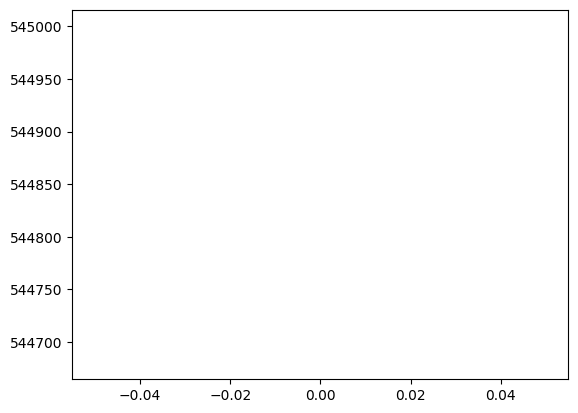

In [15]:
plt.plot(jnp.fft.fft(power_vs_time_from_results(results, z_index=-1, dx=dx, dy=dy)))
plt.plot(jnp.fft.fft(power_vs_time_from_results(results, z_index=0, dx=dx, dy=dy)))